<a href="https://colab.research.google.com/github/glouwa/app-kandinsky-pattern-generator/blob/master/kandinsky_multilabel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libs and Files

In [1]:
!rm -r sample_data 
!wget https://github.com/glouwa/app-kandinsky-pattern-generator/raw/master/lib.py
!wget https://github.com/Hvass-Labs/TensorFlow-Tutorials/raw/master/images/parrot_cropped1.jpg

--2019-06-04 20:25:03--  https://github.com/glouwa/app-kandinsky-pattern-generator/raw/master/lib.py
Resolving github.com (github.com)... 13.250.177.223
Connecting to github.com (github.com)|13.250.177.223|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/glouwa/app-kandinsky-pattern-generator/master/lib.py [following]
--2019-06-04 20:25:03--  https://raw.githubusercontent.com/glouwa/app-kandinsky-pattern-generator/master/lib.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5214 (5.1K) [text/plain]
Saving to: ‘lib.py’

lib.py              100%[===================>]   5.09K  --.-KB/s    in 0s      

2019-06-04 20:25:04 (40.4 MB/s) - ‘lib.py’ saved [5214/5214]

--2019-06-04 20:25:06--  https://github.

In [2]:
from IPython.display import display, SVG
from functools import reduce
from random import seed, randint
from numpy import array, argmax
from google.colab import widgets
import google.colab.widgets as colab_widgets
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import keras
import PIL
import json
import lib
import os 
import pickle # people say import sPickle as pickle is faster

Using TensorFlow backend.


# Intro



## Encoding
X.shape = (samples, 224, 224, 3)

Y.shape = (samples, ?)

for y we can combine multible properies of a sample. 
the output shape is defined by their amount and encodings.


In [40]:
#@title Common Stuff { vertical-output: true } 
image_shape  = (224, 224)
input_shape  = (*image_shape, 3)
output_shape = (12)

print('input_shape', input_shape, 'output_shape', output_shape)

input_shape (224, 224, 3) output_shape 12


In [0]:
max_count       = output_shape
fig_id_format   = '%s/fig%06d'
fig_path_format = './figures/%s.pkl'
png_path_format = './images/%s.png'

os.makedirs('./figures/', exist_ok=True)
os.makedirs('./images/', exist_ok=True)

def save_figure(fid, fig):    
    os.makedirs('./figures/%s'%fid.split('/')[0], exist_ok=True)
    #print("create ir", path)
    with open(fig_path_format%fid, 'wb+') as dbfile:
        pickle.dump(fig, dbfile)               

def load_figure(fid):
    with open(fig_path_format%fid, 'rb') as dbfile:
        return pickle.load(dbfile)

def load_pil(fid):
    return PIL.Image.open(png_path_format%fid).resize(image_shape, PIL.Image.LANCZOS)    

def save_pil(fid, pil):
    os.makedirs('./images/%s'%fid.split('/')[0], exist_ok=True)
    pil.save(png_path_format%(fid))

def load_image(path): # used to predict image which are not in sets (like parrot)
    return PIL.Image.open(path).resize(image_shape, PIL.Image.LANCZOS)

to_onehot    = lambda val, max_int: [1 if val == i else 0 for i in range(max_int)]
count_color  = lambda f, c: reduce(lambda a, e: a + (1 if e.color==c else 0), f, 0)
count_shape  = lambda f, c: reduce(lambda a, e: a + (1 if e.shape==c else 0), f, 0)
count_size   = lambda f, c: reduce(lambda a, e: a + (1 if e.size > c[0] and e.size <= c[1] else 0), f, 0)
to_line_list = lambda dic:"\n\t".join("{:}: {},".format(k, v) for k, v in dic.items())

# Sample *s*

Figure Configuration= {
	render_size: (224, 224),
	obj_count: (2, 15),
	obj_size: (0.1, 0.5),
	colors: ['red', 'yellow', 'blue'],
	shapes: ['circle'],
}


,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

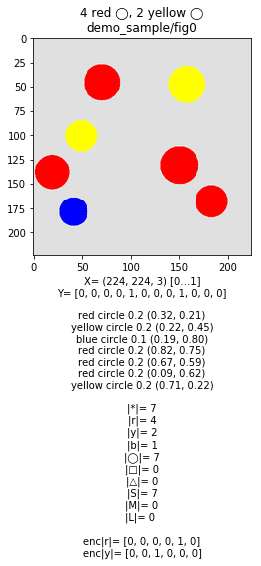

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

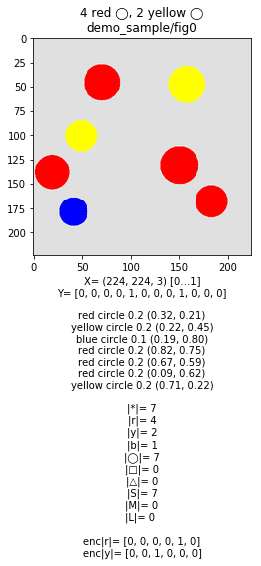

<IPython.core.display.Javascript object>

In [5]:
#@title Create a Sample { vertical-output: true }

default_figure_config = dict(   
    render_size = image_shape,
    obj_count = (2, 15),     
    obj_size = (.1, .5),
    colors = ['red','yellow', 'blue'], #['red','green', 'blue', 'yellow', 'orange'],
    shapes = ['circle']
)

class Sample:  
    def __init__(self, id, fig_cfg=None):
        #print('touching sample %s/%d'%(set_path, fid))        
        self.ID = id        
        self.f_config = fig_cfg
        self.f, pil = self.loadOrGenerate()            
        self.x = {            
            'fig': self.f,
            'pil': pil,
            'arr': array(pil)/255,
            #'url': pil.save(path)
        }
        self.counts = {            
            '|*|': len(self.f),
            '|r|': count_color(self.f ,'red'),
            '|y|': count_color(self.f ,'yellow'),
            '|b|': count_color(self.f ,'blue'),
            '|◯|': count_shape(self.f ,'circle'),
            '|□|': count_shape(self.f ,'rectangle'),
            '|△|': count_shape(self.f ,'trinangle'),
            '|S|': count_size(self.f , (.1, .2)),
            '|M|': count_size(self.f , (.2, .4)),
            '|L|': count_size(self.f , (.4, .5)),
        }                
        self.encoded = {
            #'encpos':   to_onehot(self.f_config.pos, 3),            
            #'enc|*|':   to_onehot(self.counts['|*|'], max_count),            
            #'enc|yL△|': to_onehot(count large yellow triangles),
            #'enc|yS△|': to_onehot(count ),
            #'enc|y△|': to_onehot(count ),
            'enc|r|':    to_onehot(self.counts['|r|'], max_count),            
            'enc|y|':    to_onehot(self.counts['|y|'], max_count),            
            #'enc|y△ left|': to_onehot(count ),
            #'enc|y△ top|': to_onehot(count ),            
            #'enc|y△ ontop r△|': to_onehot(count ),
            #'cap': []
        }        
        self.Yreadable = ', '.join(['%d red ◯'%self.counts['|r|'], '%d yellow ◯'%self.counts['|y|']])
    
    def loadOrGenerate(self):
        if os.path.isfile(fig_path_format%self.ID):
            self.f = load_figure(self.ID)                                       # schnell
        else:
            self.f = lib.RandomFigure(**self.f_config)
            save_figure(self.ID, self.f)                                        # nicht so schnell
            
        if os.path.isfile(png_path_format%self.ID):
            pil = load_pil(self.ID)                                             # ok vermutlich
        else:
            pil = lib.kandinskyFigureAsImage(self.f, width=image_shape[0])      # ok
            save_pil(self.ID, pil)
        
        return self.f, pil
    
    def __str__(self):        
        return "%s"%self.ID
        
    def compileX(self):      
        return self.x['arr']    
    
    def compileY(self):        
        return [*self.encoded['enc|r|'], *self.encoded['enc|y|']]
                
    def compilePandaColumns(self):
        return { 
            **{
                'ID': self.ID, 
                'file': "%s.png"%self.ID.split('/')[1],
                #'Xshape': self.x['arr'].shape, 
                'Yreadable': self.Yreadable
            },
            **self.counts,
            **self.encoded
        }
    
    def plot(self, verbose=0, title_prefix=None, X=None, Y=None):
        X = X if X is not None else self.x['arr']         
        Y = Y if Y is not None else self.compileY()        
        title_prefix = title_prefix if title_prefix is not None else self.Yreadable
        #print(title_prefix )
        fig_str =  '\n'.join([str(f) for f in self.f])
        x_dim =    '%s [%.0f…%.0f]'%(X.shape, np.min(X), np.max(X))
        counts =   '\n'.join(['%s= %s'%(k, v) for k, v in self.counts.items()])
        encoded =  '\n'.join(['%s= %s'%(k, v) for k, v in self.encoded.items()])        
        
        #plt.xlabel('\n'.join([x_dim, y_str, fig_str, counts, encoded]))
        if verbose == 0: plt.xlabel('X= %s\nY= %s'%(x_dim, Y))        
        if verbose == 1: plt.xlabel('X= %s\nY= %s\n\n%s'%(x_dim, Y, counts))        
        if verbose == 2: plt.xlabel('X= %s\nY= %s\n\n%s\n\n%s \n\n%s'%(x_dim, Y, fig_str, counts, encoded))        
            
        plt.imshow(X)
        plt.title('\n'.join([title_prefix, str(self)]))        
        plt.show()
        
print("Figure Configuration= {\n\t%s\n}"%to_line_list(default_figure_config))

grid = widgets.Grid(1, 2)
with grid.output_to(0, 0):
    example = Sample('demo_sample/fig0', default_figure_config)
    example.plot(verbose=2)        

with grid.output_to(0, 1):
    example_loaded = Sample('demo_sample/fig0', default_figure_config)
    example_loaded.plot(verbose=2)

 # Sample Set

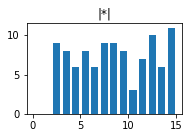

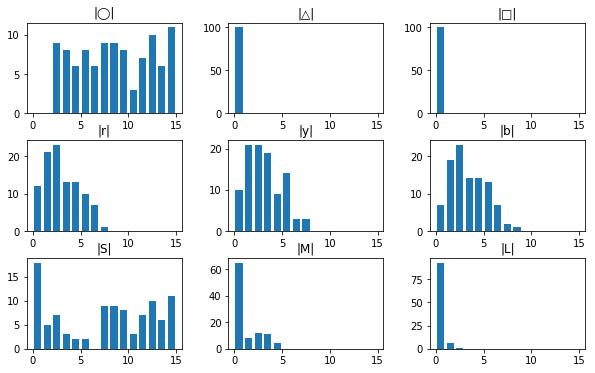

In [6]:
#@title First Batch { vertical-output: true }

def generate_batch(set_path, figure_config, batch_size, batch_idx):  
    #print('generating', n_samples)
    X = list()
    y = list()
    c = list()
    for i in range(0, batch_size):
        ID = fig_id_format%(set_path, batch_idx * batch_size + i)
        s = Sample(ID, figure_config)
        X.append(s.compileX())
        y.append(s.compileY())
        c.append({ 'BID':batch_idx, 'BPOS':i, **s.compilePandaColumns()})

    assert(len(np.array(X).shape) == 4)    
    assert(len(np.array(y).shape) == 2)
    index = pd.RangeIndex(batch_idx*batch_size, (batch_idx+1)*batch_size)
    return array(X), array(y), pd.DataFrame(index=index, data=c)
    
def sklearn_class_weight_from_vector(v):
    classes = f['Yreadable']
    return compute_class_weight(class_weight='balanced', classes=np.unique(classes), y=classes)

def sklearn_class_weight_from_frame(f):
    return sklearn_class_weight_from_vector(f['Yreadable'])
    
def display_batch_stats(f, fig_cfg):    
    max_objects = fig_cfg['obj_count'][1]
    args = { 
        'rwidth': .75,
        'range': (0, max_objects),
        'bins': max_objects,
        'grid': False,
        'align': 'mid' #'left', 'mid', 'right'
    }
    fig = plt.figure(figsize=(10, 6))# tight_layout=True)    
    f.hist(column='|*|', **args, ax=fig.add_subplot(331))    
    fig = plt.figure(figsize=(10, 6))
    f.hist(column='|◯|', **args, ax=fig.add_subplot(331)) # Divide into a 1x4 grid, give first section    
    f.hist(column='|△|', **args, ax=fig.add_subplot(332))
    f.hist(column='|□|', **args, ax=fig.add_subplot(333))    
    f.hist(column='|r|', **args, ax=fig.add_subplot(334))
    f.hist(column='|y|', **args, ax=fig.add_subplot(335))
    f.hist(column='|b|', **args, ax=fig.add_subplot(336))
    f.hist(column='|S|', **args, ax=fig.add_subplot(337))
    f.hist(column='|M|', **args, ax=fig.add_subplot(338))
    f.hist(column='|L|', **args, ax=fig.add_subplot(339))
        
_, _, f = generate_batch('view_batch', default_figure_config, 100, 0)    
display_batch_stats(f, default_figure_config)

In [0]:
# https://github.com/keras-team/keras/issues/12586
from tensorflow.python.keras.utils.data_utils import Sequence

class DataGenerator(Sequence):
#class DataGenerator(keras.utils.Sequence):  
    'Generates kandinsky data for Keras'
    def __init__(self, set_path="err", samples=1000, batch_size=32, in_dim=None, out_dim=None, figure_parameters=None):        
        self.set_path = set_path
        self.figure_parameters = figure_parameters
        self.n_samples = samples        
        self.batch_size = batch_size        
        self.in_dim = in_dim                
        self.out_dim = out_dim
        
    def __len__(self):
        'Denotes the number of batches per epoch'        
        return int(np.floor(self.n_samples / self.batch_size))

    def __getitem__(self, idx):         
        X, y, f = generate_batch(self.set_path, self.figure_parameters, self.batch_size, idx)                
        return X, y
    
    def renderFrame(self):
        panda = pd.DataFrame()
        for idx in range(len(self)):
            X, y, f = generate_batch(self.set_path, self.figure_parameters, self.batch_size, idx)        
            panda = panda.append(f)    
        print(len(self), self.set_path, "Batches touched (%s)"%self.set_path)
        self.panda = PandaSet(panda, self)
        return self
    
class PandaSet:        
    def __init__(self, f, generator, source_generator=None, index_bound_generator=None):
        "bound to the generator which created the data by BID and BPOS"
        self.f = f
        self.generator = generator
        self.class_weight = sklearn_class_weight_from_frame(self.f)        
       
    def display_meta(self, fig_cfg):                                            ## about the whole set
        "all abount the set properties"               
        print("\nshape=", self.f.shape)
        t = colab_widgets.TabBar(["Info", "Plots"])    
        with t.output_to(0):
            print("Figure Configuration= {\n\t%s\n}"%to_line_list(fig_cfg))
            print("\nMax |r| in training set=", np.max(self.f['|r|'] + 1))
            print("\nClass names=", np.unique(self.f['Yreadable'])) 
            print("\nsklearn classweights= ", self.class_weight)
            print("\nPanda info=")
            self.f.info()            
        with t.output_to(1): 
            display_batch_stats(self.f, fig_cfg) 

    def display_content_slice(self, slicePanda, sample_view=lambda s, r: s.plot(verbose=1), assert_view=None):               ## just a slice of it
        "show samples in detail"
        "by slice of panda"
        def display_XY():
            visible_samples = slicePanda.stop - slicePanda.start
            grid = colab_widgets.Grid(visible_samples, 2)            
            for i, (row_idx, sample_row) in enumerate(self.f.iloc[slicePanda].iterrows()):
                BID = sample_row['BID']
                BPOS = sample_row['BPOS']
                batch = self.generator[BID]                
                with grid.output_to(i, 0): display(batch[0][BPOS])
                with grid.output_to(i, 1): display(batch[1][BPOS])
        def display_sample():
            grid = colab_widgets.Grid(2, slicePanda.stop - slicePanda.start)
            for i, (row_idx, sample_row) in enumerate(self.f.iloc[slicePanda].iterrows()):
                ID = sample_row['ID']
                sample = Sample(ID, default_figure_config)                
                with grid.output_to(0, i):
                    sample_view(sample, sample_row) 
                with grid.output_to(1, i):
                    if assert_view:                        
                        assert_view(sample, sample_row, row_idx, self.generator)
        
        t = colab_widgets.TabBar(["Panda", "Encoded X and Y", "Sample View"])        
        with t.output_to("Panda"): display(self.f.iloc[slicePanda])             # panda slice  
        with t.output_to("Encoded X and Y"): display_XY()                       # X and Y encoded            
        with t.output_to("Sample View"): display_sample()
            

# Creating Training Data

And cerates the images and figure files

571 train Batches touched (train)
47 valid Batches touched (valid)

shape= (11991, 17)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Figure Configuration= {
	render_size: (224, 224),
	obj_count: (2, 15),
	obj_size: (0.1, 0.5),
	colors: ['red', 'yellow', 'blue'],
	shapes: ['circle'],
}

Max |r| in training set= 12

Class names= ['0 red ◯, 0 yellow ◯' '0 red ◯, 1 yellow ◯' '0 red ◯, 10 yellow ◯'
 '0 red ◯, 2 yellow ◯' '0 red ◯, 3 yellow ◯' '0 red ◯, 4 yellow ◯'
 '0 red ◯, 5 yellow ◯' '0 red ◯, 6 yellow ◯' '0 red ◯, 7 yellow ◯'
 '0 red ◯, 8 yellow ◯' '0 red ◯, 9 yellow ◯' '1 red ◯, 0 yellow ◯'
 '1 red ◯, 1 yellow ◯' '1 red ◯, 10 yellow ◯' '1 red ◯, 11 yellow ◯'
 '1 red ◯, 2 yellow ◯' '1 red ◯, 3 yellow ◯' '1 red ◯, 4 yellow ◯'
 '1 red ◯, 5 yellow ◯' '1 red ◯, 6 yellow ◯' '1 red ◯, 7 yellow ◯'
 '1 red ◯, 8 yellow ◯' '1 red ◯, 9 yellow ◯' '10 red ◯, 1 yellow ◯'
 '10 red ◯, 2 yellow ◯' '10 red ◯, 4 yellow ◯' '11 red ◯, 1 yellow ◯'
 '11 red ◯, 2 yellow ◯' '11 red ◯, 3 yellow ◯' '2 red ◯, 0 yellow ◯'
 '2 red ◯, 1 yellow ◯' '2 red ◯, 10 yellow ◯' '2 red ◯, 2 yellow ◯'
 '2 red ◯, 3 yellow ◯' '2 red ◯, 4 yellow ◯' '2 red ◯, 5 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

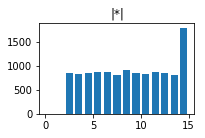

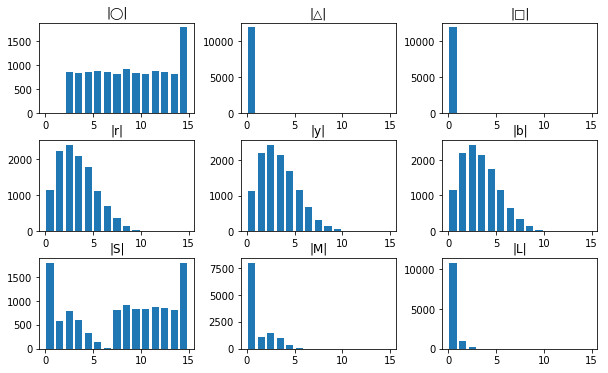

<IPython.core.display.Javascript object>

CPU times: user 3min 21s, sys: 4.33 s, total: 3min 25s
Wall time: 3min 25s


In [8]:
#@title Create Training/Validation Set. Show Training Set (f, fig_cfg) { vertical-output: true }
%%time

batch_size      = 21 #@param {type:"slider", min:1, max:200, step:5}
training_size   = 16000 #@param {type:"slider", min:100, max:20000, step:100}
validation_size = 1000 #@param {type:"slider", min:100, max:1500, step:10}

params = {
    'figure_parameters': default_figure_config,
    'batch_size': batch_size,
    'in_dim': input_shape,
    'out_dim': output_shape
}

training_generator = DataGenerator(set_path="train", samples=training_size, **params).renderFrame()
validation_generator = DataGenerator(set_path="valid", samples=validation_size, **params).renderFrame()

training_generator.panda.display_meta(params['figure_parameters'])



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,BID,BPOS,ID,Yreadable,enc|r|,enc|y|,file,|*|,|L|,|M|,|S|,|b|,|r|,|y|,|□|,|△|,|◯|
9,0,9,train/fig000009,"4 red ◯, 3 yellow ◯","[0, 0, 0, 0, 1, 0]","[0, 0, 0, 1, 0, 0]",fig000009.png,11,0,0,11,4,4,3,0,0,11
10,0,10,train/fig000010,"3 red ◯, 7 yellow ◯","[0, 0, 0, 1, 0, 0]","[0, 0, 0, 0, 0, 0]",fig000010.png,11,0,0,11,1,3,7,0,0,11
11,0,11,train/fig000011,"0 red ◯, 1 yellow ◯","[1, 0, 0, 0, 0, 0]","[0, 1, 0, 0, 0, 0]",fig000011.png,3,1,2,0,2,0,1,0,0,3
12,0,12,train/fig000012,"0 red ◯, 2 yellow ◯","[1, 0, 0, 0, 0, 0]","[0, 0, 1, 0, 0, 0]",fig000012.png,2,0,1,0,0,0,2,0,0,2
13,0,13,train/fig000013,"4 red ◯, 3 yellow ◯","[0, 0, 0, 0, 1, 0]","[0, 0, 0, 1, 0, 0]",fig000013.png,9,0,0,9,2,4,3,0,0,9
14,0,14,train/fig000014,"3 red ◯, 5 yellow ◯","[0, 0, 0, 1, 0, 0]","[0, 0, 0, 0, 0, 1]",fig000014.png,11,0,0,11,3,3,5,0,0,11
15,0,15,train/fig000015,"3 red ◯, 3 yellow ◯","[0, 0, 0, 1, 0, 0]","[0, 0, 0, 1, 0, 0]",fig000015.png,11,0,0,11,5,3,3,0,0,11
16,0,16,train/fig000016,"6 red ◯, 3 yellow ◯","[0, 0, 0, 0, 0, 0]","[0, 0, 0, 1, 0, 0]",fig000016.png,15,0,0,15,6,6,3,0,0,15
17,0,17,train/fig000017,"2 red ◯, 3 yellow ◯","[0, 0, 1, 0, 0, 0]","[0, 0, 0, 1, 0, 0]",fig000017.png,7,0,0,7,2,2,3,0,0,7
18,0,18,train/fig000018,"3 red ◯, 2 yellow ◯","[0, 0, 0, 1, 0, 0]","[0, 0, 1, 0, 0, 0]",fig000018.png,7,0,0,7,2,3,2,0,0,7


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,
,
,
,
,
,
,
,
,
,
,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       ...,

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       ...,

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       ...,

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       ...,

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       ...,

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       ...,

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       ...,

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       ...,

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       ...,

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       ...,

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       ...,

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       ...,

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       ...,

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       ...,

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       ...,

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       ...,

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       ...,

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       ...,

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       ...,

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       ...,

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

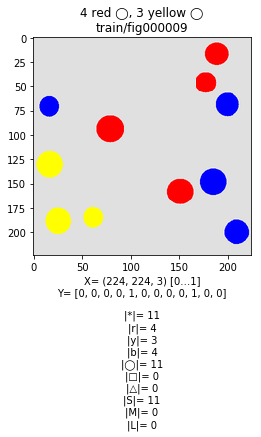

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

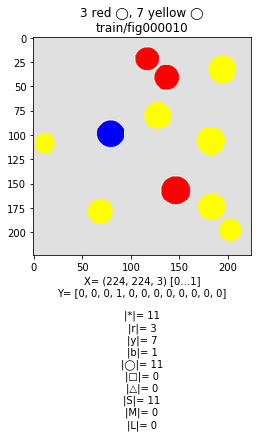

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

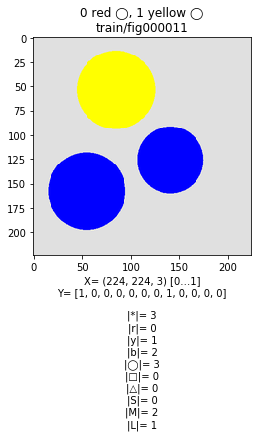

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

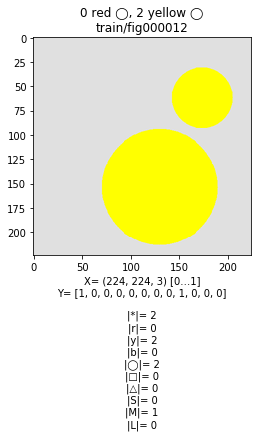

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

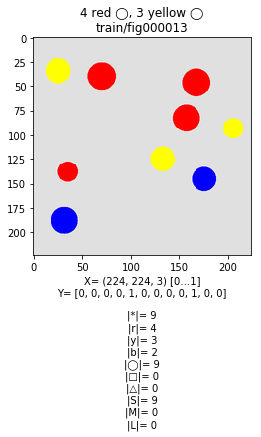

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

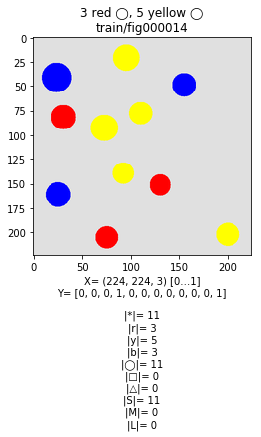

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

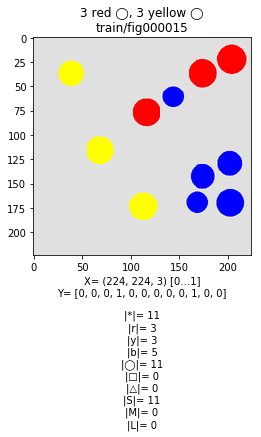

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

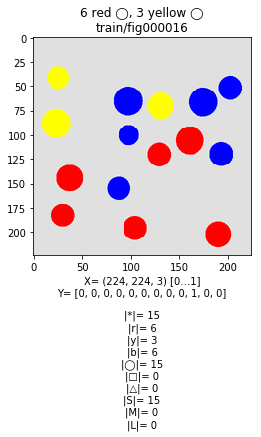

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

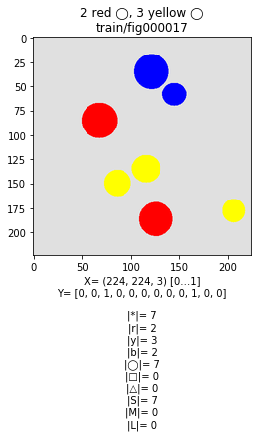

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

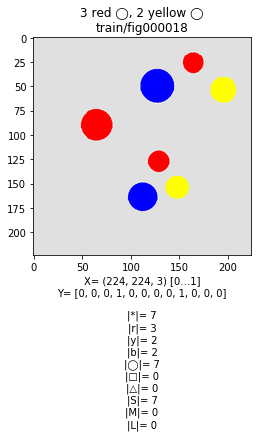

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

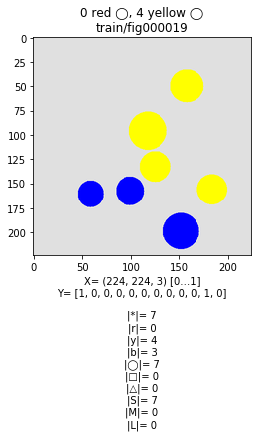

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

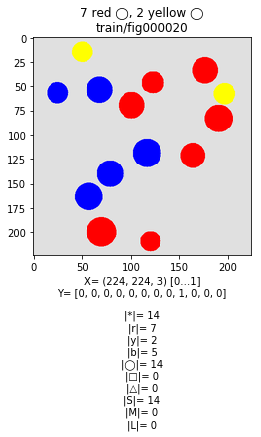

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

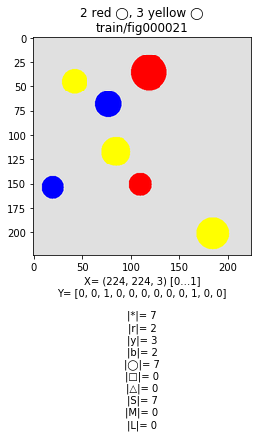

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

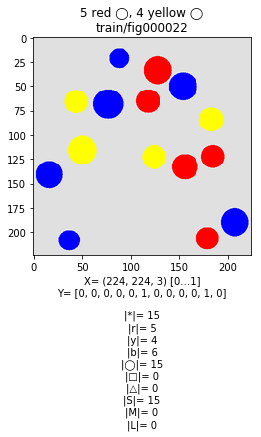

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

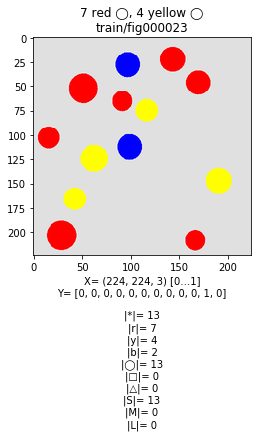

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

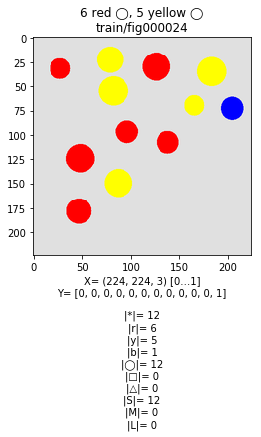

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

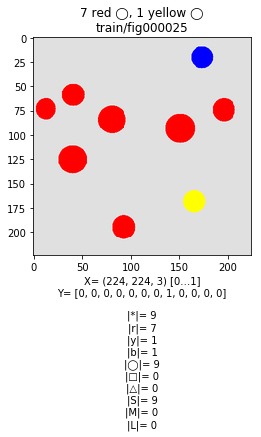

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

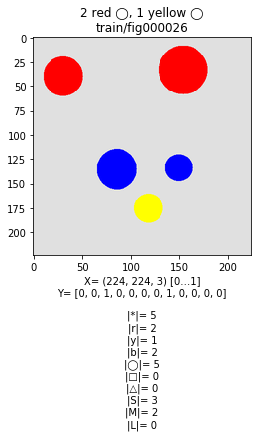

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

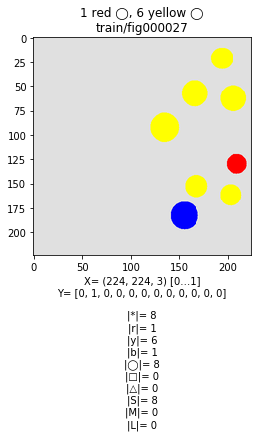

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

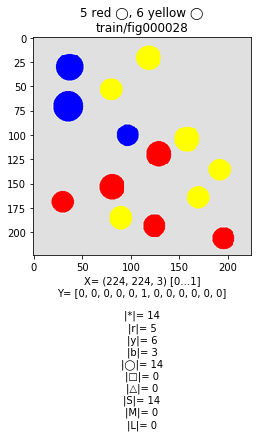

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [9]:
#@title Review Training Generator Content (X, Y, f) (Sample View) { run: "auto", vertical-output: true }

sample_to_view  = 9 #@param {type:"slider", min:0, max:20000, step:1}
view_len = 20 #@param {type:"slider", min:1, max:20, step:1}

training_generator.panda.display_content_slice(slice(sample_to_view, sample_to_view + view_len))



# Just for Fun: Remove some Samples from Training Set

['0 red ◯, 0 yellow ◯', '0 red ◯, 1 yellow ◯', '0 red ◯, 2 yellow ◯', '0 red ◯, 3 yellow ◯', '0 red ◯, 4 yellow ◯', '1 red ◯, 0 yellow ◯', '1 red ◯, 1 yellow ◯', '1 red ◯, 2 yellow ◯', '1 red ◯, 3 yellow ◯', '1 red ◯, 4 yellow ◯', '2 red ◯, 0 yellow ◯', '2 red ◯, 1 yellow ◯', '2 red ◯, 2 yellow ◯', '2 red ◯, 3 yellow ◯', '2 red ◯, 4 yellow ◯', '3 red ◯, 0 yellow ◯', '3 red ◯, 1 yellow ◯', '3 red ◯, 2 yellow ◯', '3 red ◯, 3 yellow ◯', '3 red ◯, 4 yellow ◯', '4 red ◯, 0 yellow ◯', '4 red ◯, 1 yellow ◯', '4 red ◯, 2 yellow ◯', '4 red ◯, 3 yellow ◯', '4 red ◯, 4 yellow ◯']

shape= (7868, 17)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Figure Configuration= {
	render_size: (224, 224),
	obj_count: (2, 15),
	obj_size: (0.1, 0.5),
	colors: ['red', 'yellow', 'blue'],
	shapes: ['circle'],
}

Max |r| in training set= 5

Class names= ['0 red ◯, 0 yellow ◯' '0 red ◯, 1 yellow ◯' '0 red ◯, 2 yellow ◯'
 '0 red ◯, 3 yellow ◯' '0 red ◯, 4 yellow ◯' '1 red ◯, 0 yellow ◯'
 '1 red ◯, 1 yellow ◯' '1 red ◯, 2 yellow ◯' '1 red ◯, 3 yellow ◯'
 '1 red ◯, 4 yellow ◯' '2 red ◯, 0 yellow ◯' '2 red ◯, 1 yellow ◯'
 '2 red ◯, 2 yellow ◯' '2 red ◯, 3 yellow ◯' '2 red ◯, 4 yellow ◯'
 '3 red ◯, 0 yellow ◯' '3 red ◯, 1 yellow ◯' '3 red ◯, 2 yellow ◯'
 '3 red ◯, 3 yellow ◯' '3 red ◯, 4 yellow ◯' '4 red ◯, 0 yellow ◯'
 '4 red ◯, 1 yellow ◯' '4 red ◯, 2 yellow ◯' '4 red ◯, 3 yellow ◯'
 '4 red ◯, 4 yellow ◯']

sklearn classweights=  [1.25       0.83333333 1.25       1.25       1.25       2.5
 0.5        0.5        0.5        1.25       2.5        1.25
 2.5        1.25       0.35714286 0.625      0.5        1.25
 0.83333333 0.83333333 1.25       1.25 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

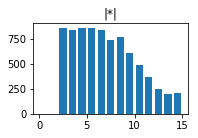

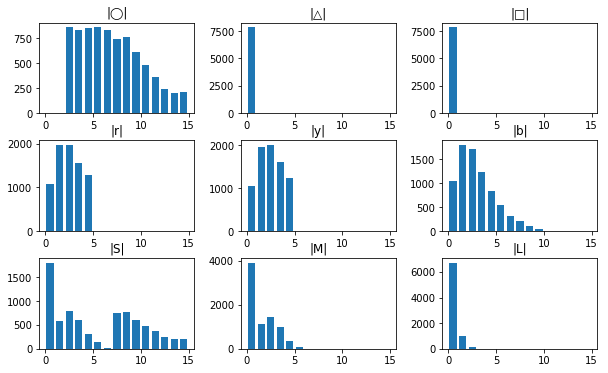

<IPython.core.display.Javascript object>

In [10]:
#@title Select Classes (training_panda → training_panda_filterd) { vertical-output: true }

#training_generator.panda = training_generator.panda.astype({"Yreadable": str})
#training_generator.panda = training_generator.panda.infer_objects()

#v = range(0, 5) 
#v+=' red ◯'

#v = range(0, 5) 
#v+=' yellow ◯'

# cross product vr vy

classes = list()
for r in range(0, 5):
    for y in range(0, 5):
        classes.append('%d red ◯, %d yellow ◯'%(r, y))

print(classes)
        
def filter_panda(panda):
    return panda.loc[panda['Yreadable'].isin(classes)]

training_panda_filterd = PandaSet(filter_panda(training_generator.panda.f), training_generator)
validation_panda_filterd = PandaSet(filter_panda(validation_generator.panda.f), validation_generator)

training_panda_filterd.display_meta(params['figure_parameters'])

# Generator Chain

In [0]:
from keras.preprocessing.image import ImageDataGenerator

argumented_training_generator = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 180,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    zoom_range = [1, 1.5],
    horizontal_flip = True,
    vertical_flip = True,
    fill_mode = 'nearest'
)
argumented_validation_generator = ImageDataGenerator(rescale=1./255)

In [0]:
#@title Data Augmentation and Y Declaration { vertical-output: true }

class AugmentationGenerator(Sequence): # same element count, but transformed elements
    def __init__(self, decorated):        
        self.decorated = decorated
        self.batch_size = decorated.batch_size
        self.last_batch_id = -1
        
    def __len__(self):        
        return len(self.decorated)

    def __getitem__(self, idx):         
        X, Y, = self.getBatchCached(idx)
        for i in range(len(X)):        
            X[i] = argumented_training_generator.random_transform(X[i])            
        return X, Y
    
    def getBatchCached(self, idx):
        if  self.last_batch_id != idx:
            self.last_batch = self.decorated[idx]
            self.last_batch_id = idx
        return self.last_batch
    
class FromFrameGenerator(Sequence): # filters elements
    def __init__(self, decorated, panda_frame):        
        self.decorated = decorated
        self.batch_size = decorated.batch_size
        self.panda_frame = panda_frame
        self.last_batch_id = None
        
    def __len__(self):        
        return int(len(self.panda_frame) / self.batch_size)

    def __getitem__(self, idx):
        batch_panda = self.panda_frame.iloc[idx*self.batch_size : (idx+1)*self.batch_size]
        X = list()
        Y = list()
        last_batch_id = None
        for i, (row_idx, sample_row) in enumerate(batch_panda.iterrows()):
            current_batch_id = sample_row['BID']   
            current_batch_pos = sample_row['BPOS']            
            batch = self.getBatchCached(current_batch_id)
            X.append(batch[0][current_batch_pos])
            Y.append(batch[1][current_batch_pos])
        
        return np.array(X), np.array(Y)
    
    def getBatchCached(self, idx):
        if not self.last_batch_id or self.last_batch_id != idx:
            self.last_batch = self.decorated[idx]
            self.last_batch_id = idx
        return self.last_batch
    
training_filtered = PandaSet(
    training_panda_filterd.f, 
    FromFrameGenerator(training_generator, training_panda_filterd.f)
)
training_augmented = PandaSet(
    training_panda_filterd.f, 
    AugmentationGenerator(training_filtered.generator)
)
training_augmented.display_content_slice(
    slice(0, 5),
    assert_view = lambda s, r, ridx, g: s.plot(        
        X=g[r['BID']][0][r['BPOS']], 
        Y=g[r['BID']][1][r['BPOS']]
    )
)

validation_filtered = PandaSet(
    validation_panda_filterd.f, 
    FromFrameGenerator(validation_generator, validation_panda_filterd.f)
)
validation_augmented = PandaSet(
    validation_panda_filterd.f, 
    AugmentationGenerator(validation_filtered.generator)
)

# Data ready - Load  VGG16

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

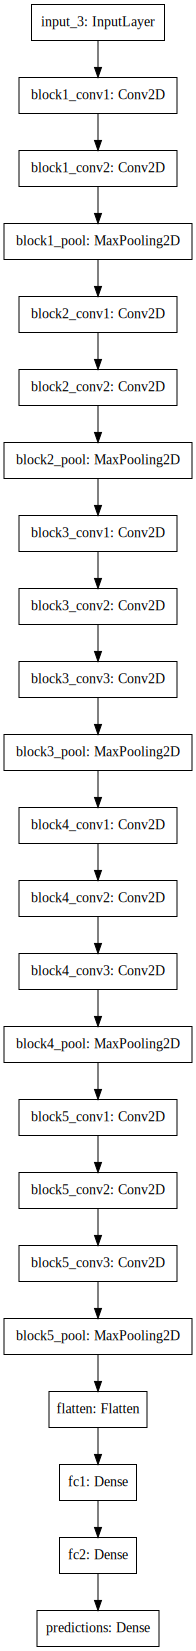

In [33]:
#@title Download VGG16 { vertical-output: true, output-height: 400 }

vgg16_init_weights = 'imagenet' #@param ["'imagenet'", "None"] {type:"raw"}

from tensorflow.python.keras.applications import VGG16

vgg16model = VGG16(include_top=True, weights=vgg16_init_weights)
vgg16model.summary()
SVG(keras.utils.vis_utils.model_to_dot(vgg16model).create(prog='dot', format='svg'))

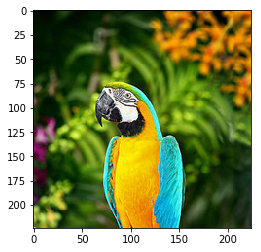

79.02% : macaw
 6.61% : bubble
 3.64% : vine_snake
 1.90% : pinwheel
 1.22% : knot


In [34]:
#@title Make a prediction with vgg16 imagenet weights{ vertical-output: true }

from tensorflow.python.keras.applications.vgg16 import preprocess_input, decode_predictions

def predict(image_array):
    plt.imshow(image_array)
    plt.show()
    
    img_array = np.expand_dims(image_array, axis=0)   
    
    pred = vgg16model.predict(img_array)
    pred_decoded = decode_predictions(pred)[0]
    
    for code, name, score in pred_decoded:
        print("{0:>6.2%} : {1}".format(score, name))  
        
predict(load_image('parrot_cropped1.jpg'))
#predict(image_path=image_paths_train[0])

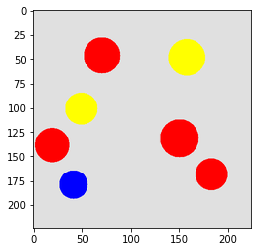

 5.21% : envelope
 3.41% : mosquito_net
 3.16% : toilet_tissue
 2.86% : shower_curtain
 1.97% : photocopier


In [35]:
#@title predict a Kandinsky Figure with VGG16 imagenet weights { vertical-output: true }
predict(example.x['arr'])

# Creating a Model: VGG16[0:block5_pool] + 2 new Dense Layers

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_3 (Model)              (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 1024)              25691136  
_________________________________________________________________
dropout_3 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 12)                12300     
Total params: 40,418,124
Trainable params: 40,418,124
Non-trainable params: 0
_________________________________________________________________


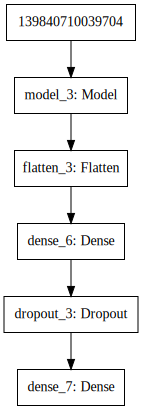

In [41]:
#@title Creating a new Model { vertical-output: true, output-height: 300 }
n1           = 100 #@param {type:"slider", min:1, max:500, step:1}
n2           = 50 #@param {type:"slider", min:1, max:500, step:1}

from tensorflow.python.keras.models import Model, Sequential
from tensorflow.python.keras.layers import Dense, Flatten, Dropout
from tensorflow.python.keras.optimizers import Adam, RMSprop

conv_model = Model(inputs=vgg16model.input, outputs=vgg16model.get_layer('block5_pool').output)

new_model = Sequential()
new_model.add(conv_model)
new_model.add(Flatten())
new_model.add(Dense(1024, activation='relu'))
new_model.add(Dropout(0.5))
new_model.add(Dense(output_shape, activation='softmax'))

new_model.summary()
SVG(keras.utils.vis_utils.model_to_dot(new_model).create(prog='dot', format='svg'))

In [42]:
#@title Compile after trainable Layers are set { vertical-output: true }
optimizer     = "adam"                     #@param ["adam" ,"other"]
learning_rate = 0.01                       #@param {type:"slider", min:1e-7, max:0.01, step:1e-3}
loss          = "categorical_crossentropy" #@param ["categorical_crossentropy", "whatever"]
main_metric   = "categorical_accuracy"     #@param ["accuracy", "categorical_accuracy"]
train_vgg16   = True #@param {type:"boolean"}

print(' '.join([str(layer.trainable) for layer in conv_model.layers]), '\n')

conv_model.trainable = train_vgg16
for layer in conv_model.layers: layer.trainable = train_vgg16
    
new_model.compile(
    optimizer = Adam(lr=1e-5), 
    loss = loss, 
    metrics = [main_metric]
)

print(' '.join([str(layer.trainable) for layer in conv_model.layers]), '\n')


True True True True True True True True True True True True True True True True True True True 

True True True True True True True True True True True True True True True True True True True 



# Training

In [0]:
#used_training_generator = training_generator                   # the unfiltered first DataGenerator 
used_training_generator = training_augmented.generator

used_validation_generator = validation_augmented.generator
#used_validation__generator = validation__generator_from_table
#used_validation_generator = validation_generator_from_directory

#class_weight = class_weight_raw
class_weight = training_panda_filterd.class_weight
#class_weight = class_weight_from_directory

batch_size= 21 batch_count= 374 samples*= 7854 
epochs= 2 steps_per_epoch= 112 samples_per_step*= 70
Epoch 1/2
374/374 [==============================] - 181s 484ms/step - loss: 3.8121 - categorical_accuracy: 0.2531 - val_loss: 2.8583 - val_categorical_accuracy: 0.4095
Epoch 2/2
374/374 [==============================] - 174s 466ms/step - loss: 2.7829 - categorical_accuracy: 0.4158 - val_loss: 2.2429 - val_categorical_accuracy: 0.4603


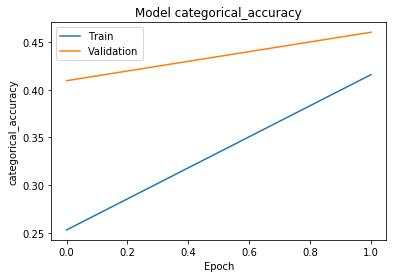

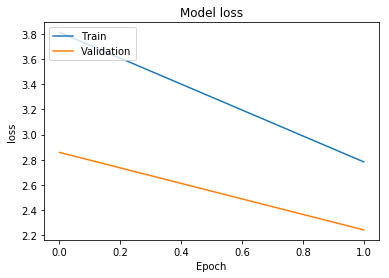

categorical_accuracy = 0.41583908
val_categorical_accuracy = 0.46031746
CPU times: user 8min 2s, sys: 1min 22s, total: 9min 25s
Wall time: 5min 59s


In [44]:
#@title Training { vertical-output: true }
%%time

steps_per_epoch    = 112 #@param {type:"slider", min:10, max:500, step:1}
epochs             = 2 #@param {type:"slider", min:1, max:50, step:1}
learning_rate      = 30 #@param {type:"slider", min:1, max:50, step:1}
trained_layers     = 'dense' #@param ["'all'", "'dense'", "'vgg16[5,6]'"] {type:"raw"}
use_multprocessing = False #@param {type:"boolean"}
workers            = 8 #@param {type:"slider", min:1, max:64, step:1}
verbose            = 1 #@param {type:"slider", min:0, max:5, step:1}

print(
    "batch_size=", used_training_generator.batch_size, 
    "batch_count=", len(used_training_generator), 
    "samples*=", used_training_generator.batch_size * len(used_training_generator), 
    "\nepochs=", epochs, 
    "steps_per_epoch=", steps_per_epoch, 
    "samples_per_step*=", int(used_training_generator.batch_size * len(used_training_generator) 
                              / steps_per_epoch)
)

fit_result1 = new_model.fit_generator(    
    epochs = epochs,
    steps_per_epoch = steps_per_epoch,    
    
    generator = used_training_generator,  
    validation_data = used_validation_generator,
    
    class_weight = class_weight,
    #use_multiprocessing = use_multprocessing,    
    #workers = workers,
    verbose = verbose
)

def plot_metric(history, m):        
        plt.plot(history[m])
        plt.plot(history['val_%s'%m])
        plt.title('Model %s'%m)
        plt.ylabel(m)
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')
        plt.show()
    
def plot_history(history):    
    plot_metric(history, main_metric)
    plot_metric(history, 'loss')
    print(main_metric,          "=", history[main_metric][-1])
    print("val_%s"%main_metric, "=", history["val_%s"%main_metric][-1])

#history_merge =  merge_history(history_merge, fit_result2.history) if history_merge else fit_result1.history
history_merge = fit_result1.history
plot_history(history_merge)

374/374 [==============================] - 178s 476ms/step - loss: 2.3827 - categorical_accuracy: 0.4674 - val_loss: 1.9373 - val_categorical_accuracy: 0.3349
categorical_accuracy = 0.46740514


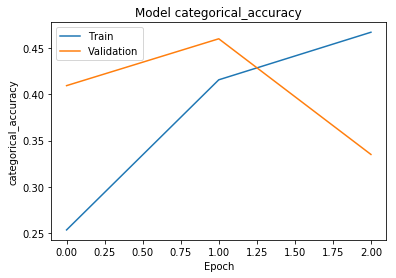

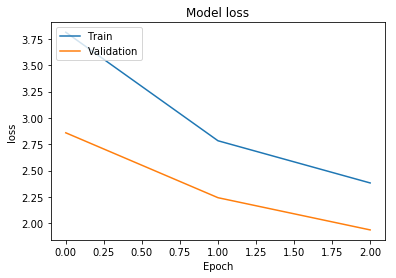

categorical_accuracy = 0.46740514
val_categorical_accuracy = 0.33492064
CPU times: user 3min 59s, sys: 40 s, total: 4min 39s
Wall time: 2min 58s


In [45]:
#@title Training { vertical-output: true }
%%time

epochs             = 1 #@param {type:"slider", min:1, max:50, step:1}
learning_rate      = 2 #@param {type:"slider", min:1, max:50, step:1}
trained_layers     = 'all' #@param ["'all'", "'vgg16'", "'vgg16[5,6]'"] {type:"raw"}

fit_result2 = new_model.fit_generator(    
    epochs = epochs,
    steps_per_epoch = steps_per_epoch,    
    
    generator = used_training_generator,  
    validation_data = used_validation_generator,
    
    class_weight = class_weight,
    #use_multiprocessing = use_multprocessing,    
    #workers = workers,
    verbose = verbose
)

print(main_metric, "=", fit_result2.history[main_metric][-1])

def merge_history(h1, h2):
    assert(h1.keys() == h2.keys())
    history_merge_values = list(map(lambda ek: h1[ek] + h2[ek], h1.keys()))
    return dict(zip(h1.keys(), history_merge_values)) 
    
history_merge = merge_history(history_merge, fit_result2.history)    
plot_history(history_merge)

# Checkpoint

In [46]:
from keras.models import load_model
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
drive_path = '/content/drive/My Drive/colab/kandinsky/%s'

In [53]:
!ls "drive/My Drive/colab/kandinsky" -l

total 789554
-rw------- 1 root root 161708800 Jun  4 20:51 multilabel_model_weights.h5
-rw------- 1 root root 485108848 Jun  4 20:51 my_model.h5
-rw------- 1 root root 161684152 May 31 21:01 my_model_weights.h5


In [0]:
new_model.save(drive_path%'multilabel_model_ry.h5')
new_model.save_weights(drive_path%'multilabel_model_ry_weights.h5')

In [0]:
#new_model_loaded = load_model(drive_path%'my_model.h5')

new_model_loaded = new_model
new_model_loaded.load_weights(drive_path%'multilabel_model_ry_weights.h5')

# Test Set 1

In [54]:
#@title Data Generators for test { vertical-output: true }
%%time
batch_size      = 31 #@param {type:"slider", min:1, max:200, step:5}
test_size       = 30000 #@param {type:"slider", min:100, max:30000, step:10}

test_params = {
    'figure_parameters': default_figure_config,
    'batch_size': batch_size,
    'in_dim': input_shape,
    'out_dim': output_shape
}

print("Figure Configuration= {\n\t%s\n}"%to_line_list(test_params['figure_parameters']))
test_generator = DataGenerator(set_path="test", samples=test_size, **test_params).renderFrame()

print("Generated class count of test set=", np.max(test_generator.panda.f['|r|']))

Figure Configuration= {
	render_size: (224, 224),
	obj_count: (2, 15),
	obj_size: (0.1, 0.5),
	colors: ['red', 'yellow', 'blue'],
	shapes: ['circle'],
}
967 test Batches touched (test)
Generated class count of test set= 11
CPU times: user 7min 44s, sys: 7.11 s, total: 7min 51s
Wall time: 7min 50s



shape= (29977, 17)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Figure Configuration= {
	render_size: (224, 224),
	obj_count: (2, 15),
	obj_size: (0.1, 0.5),
	colors: ['red', 'yellow', 'blue'],
	shapes: ['circle'],
}

Max |r| in training set= 12

Class names= ['0 red ◯, 0 yellow ◯' '0 red ◯, 1 yellow ◯' '0 red ◯, 10 yellow ◯'
 '0 red ◯, 2 yellow ◯' '0 red ◯, 3 yellow ◯' '0 red ◯, 4 yellow ◯'
 '0 red ◯, 5 yellow ◯' '0 red ◯, 6 yellow ◯' '0 red ◯, 7 yellow ◯'
 '0 red ◯, 8 yellow ◯' '0 red ◯, 9 yellow ◯' '1 red ◯, 0 yellow ◯'
 '1 red ◯, 1 yellow ◯' '1 red ◯, 10 yellow ◯' '1 red ◯, 11 yellow ◯'
 '1 red ◯, 2 yellow ◯' '1 red ◯, 3 yellow ◯' '1 red ◯, 4 yellow ◯'
 '1 red ◯, 5 yellow ◯' '1 red ◯, 6 yellow ◯' '1 red ◯, 7 yellow ◯'
 '1 red ◯, 8 yellow ◯' '1 red ◯, 9 yellow ◯' '10 red ◯, 0 yellow ◯'
 '10 red ◯, 1 yellow ◯' '10 red ◯, 2 yellow ◯' '10 red ◯, 3 yellow ◯'
 '10 red ◯, 5 yellow ◯' '11 red ◯, 1 yellow ◯' '11 red ◯, 2 yellow ◯'
 '2 red ◯, 0 yellow ◯' '2 red ◯, 1 yellow ◯' '2 red ◯, 10 yellow ◯'
 '2 red ◯, 12 yellow ◯' '2 red ◯, 2 yellow ◯' '2 red ◯, 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

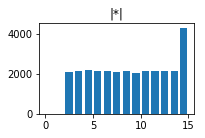

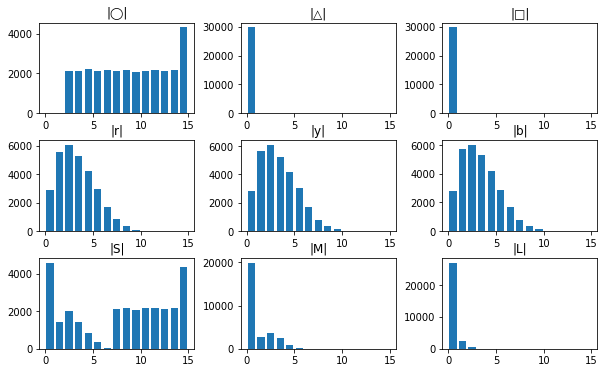

<IPython.core.display.Javascript object>

In [55]:
#@title Test set { run: "auto", vertical-output: true }
test_generator.panda.display_meta(test_params['figure_parameters'])



shape= (19494, 17)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Figure Configuration= {
	render_size: (224, 224),
	obj_count: (2, 15),
	obj_size: (0.1, 0.5),
	colors: ['red', 'yellow', 'blue'],
	shapes: ['circle'],
}

Max |r| in training set= 5

Class names= ['0 red ◯, 0 yellow ◯' '0 red ◯, 1 yellow ◯' '0 red ◯, 2 yellow ◯'
 '0 red ◯, 3 yellow ◯' '0 red ◯, 4 yellow ◯' '1 red ◯, 0 yellow ◯'
 '1 red ◯, 1 yellow ◯' '1 red ◯, 2 yellow ◯' '1 red ◯, 3 yellow ◯'
 '1 red ◯, 4 yellow ◯' '2 red ◯, 0 yellow ◯' '2 red ◯, 1 yellow ◯'
 '2 red ◯, 2 yellow ◯' '2 red ◯, 3 yellow ◯' '2 red ◯, 4 yellow ◯'
 '3 red ◯, 0 yellow ◯' '3 red ◯, 1 yellow ◯' '3 red ◯, 2 yellow ◯'
 '3 red ◯, 3 yellow ◯' '3 red ◯, 4 yellow ◯' '4 red ◯, 0 yellow ◯'
 '4 red ◯, 1 yellow ◯' '4 red ◯, 2 yellow ◯' '4 red ◯, 3 yellow ◯'
 '4 red ◯, 4 yellow ◯']

sklearn classweights=  [1.25       0.83333333 1.25       1.25       1.25       2.5
 0.5        0.5        0.5        1.25       2.5        1.25
 2.5        1.25       0.35714286 0.625      0.5        1.25
 0.83333333 0.83333333 1.25       1.25 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

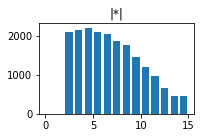

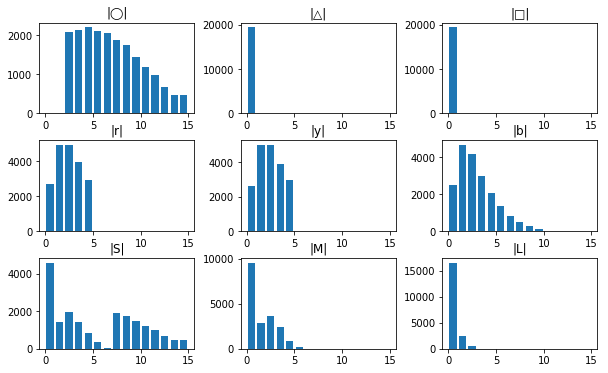

<IPython.core.display.Javascript object>

In [61]:
#@title Use same filter for test set { run: "auto", vertical-output: true }
test_panda_filterd = PandaSet(filter_panda(test_generator.panda.f), test_generator)

test_filtered = PandaSet(
    test_panda_filterd.f, 
    FromFrameGenerator(test_generator, test_panda_filterd.f)
)
test_filtered.display_meta(test_params['figure_parameters'])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,BID,BPOS,ID,Yreadable,enc|r|,enc|y|,file,|*|,|L|,|M|,|S|,|b|,|r|,|y|,|□|,|△|,|◯|
0,0,0,test/fig000000,"1 red ◯, 2 yellow ◯","[0, 1, 0, 0, 0, 0]","[0, 0, 1, 0, 0, 0]",fig000000.png,10,0,0,10,7,1,2,0,0,10
3,0,3,test/fig000003,"3 red ◯, 0 yellow ◯","[0, 0, 0, 1, 0, 0]","[1, 0, 0, 0, 0, 0]",fig000003.png,5,0,2,3,2,3,0,0,0,5
4,0,4,test/fig000004,"1 red ◯, 2 yellow ◯","[0, 1, 0, 0, 0, 0]","[0, 0, 1, 0, 0, 0]",fig000004.png,4,1,1,1,1,1,2,0,0,4
5,0,5,test/fig000005,"3 red ◯, 2 yellow ◯","[0, 0, 0, 1, 0, 0]","[0, 0, 1, 0, 0, 0]",fig000005.png,8,0,0,8,3,3,2,0,0,8
7,0,7,test/fig000007,"3 red ◯, 4 yellow ◯","[0, 0, 0, 1, 0, 0]","[0, 0, 0, 0, 1, 0]",fig000007.png,10,0,0,10,3,3,4,0,0,10


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,
,
,
,
,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       ...,

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       ...,

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       ...,

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       ...,

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       ...,

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,,,,
,,,,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

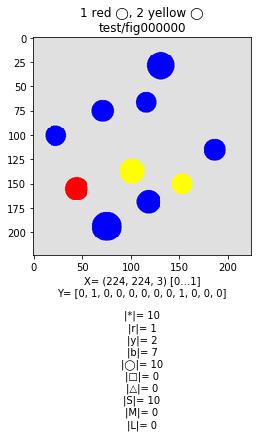

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

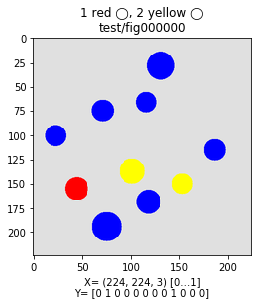

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

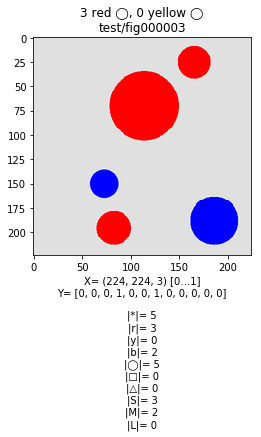

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

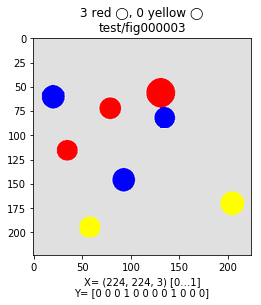

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

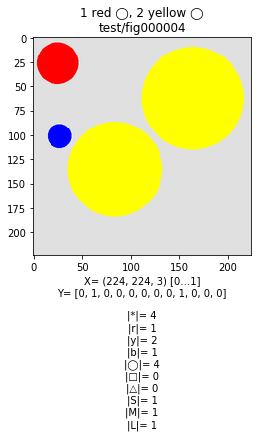

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

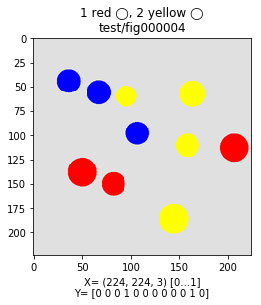

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

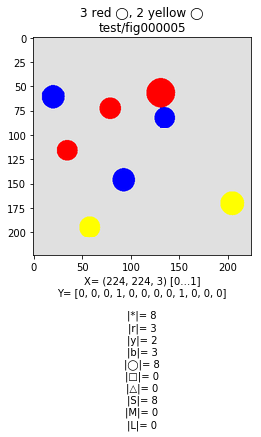

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

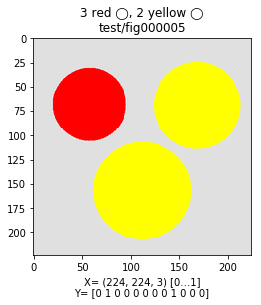

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

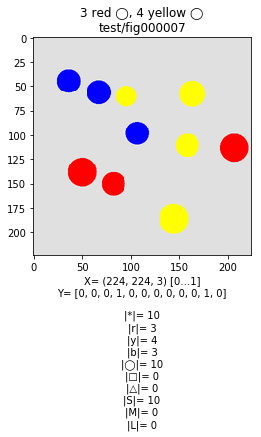

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

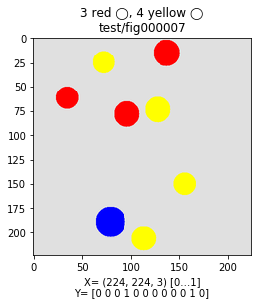

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [62]:
#@title Review Train Generator { run: "auto", vertical-output: true }

sample_to_view  = 0 #@param {type:"slider", min:0, max:20000, step:1}
view_len = 5 #@param {type:"slider", min:1, max:20, step:1}

test_filtered.display_content_slice(
    slice(sample_to_view, sample_to_view + view_len),
    assert_view = lambda s, r, ridx, g: s.plot(        
        X=g[r['BID']][0][r['BPOS']], 
        Y=g[r['BID']][1][r['BPOS']]
    )
)

# Evaluation 1

In [63]:
#@title Test Metrics { run: "auto", vertical-output: true }

used_test_generator = test_filtered.generator
used_test_panda = test_filtered.f

print("Accuracy %s" % new_model.evaluate_generator(used_test_generator, verbose=1)[1])

628/628 [==============================] - 107s 170ms/step - loss: 2.0020 - categorical_accuracy: 0.3734
Accuracy 0.37343332


In [84]:
#@title Predict and add Prediction to panda { vertical-output: true }

#y_pred = new_model.predict_generator(used_test_generator, verbose=1)
y_pred_str = [', '.join(['%d red ◯'%np.argmax(v16[0:6]), '%d yellow ◯'%np.argmax(v16[6:12])]) for v16 in y_pred]
  
print("predicted=", len(y_pred_str))
print("panda", used_test_panda.shape)
    
raw_panda = used_test_panda.iloc[0:len(y_pred_str)].copy()
raw_panda['Ypredicted'] = y_pred_str

mask = (raw_panda['Yreadable'] != raw_panda['Ypredicted'])

print("\nnumber of falsy predictions", np.sum(mask))
print("\nnumber of correct predictions", np.sum(~mask))

raw_panda['mask'] = mask

predicted= 19468
panda (19494, 17)

number of falsy predictions 1931

number of correct predictions 17537



shape= (1931, 19)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Figure Configuration= {
	render_size: (224, 224),
	obj_count: (2, 15),
	obj_size: (0.1, 0.5),
	colors: ['red', 'yellow', 'blue'],
	shapes: ['circle'],
}

Max |r| in training set= 5

Class names= ['0 red ◯, 3 yellow ◯' '0 red ◯, 4 yellow ◯' '1 red ◯, 2 yellow ◯'
 '1 red ◯, 3 yellow ◯' '1 red ◯, 4 yellow ◯' '2 red ◯, 0 yellow ◯'
 '2 red ◯, 1 yellow ◯' '2 red ◯, 2 yellow ◯' '2 red ◯, 3 yellow ◯'
 '2 red ◯, 4 yellow ◯' '3 red ◯, 0 yellow ◯' '3 red ◯, 1 yellow ◯'
 '3 red ◯, 2 yellow ◯' '3 red ◯, 3 yellow ◯' '3 red ◯, 4 yellow ◯'
 '4 red ◯, 0 yellow ◯' '4 red ◯, 1 yellow ◯' '4 red ◯, 2 yellow ◯'
 '4 red ◯, 3 yellow ◯' '4 red ◯, 4 yellow ◯']

sklearn classweights=  [1.25       0.83333333 1.25       1.25       1.25       2.5
 0.5        0.5        0.5        1.25       2.5        1.25
 2.5        1.25       0.35714286 0.625      0.5        1.25
 0.83333333 0.83333333 1.25       1.25       0.83333333 0.83333333
 2.5        1.25       0.625      0.83333333 2.5        2.5
 2.5        0.625      1

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

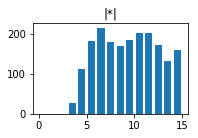

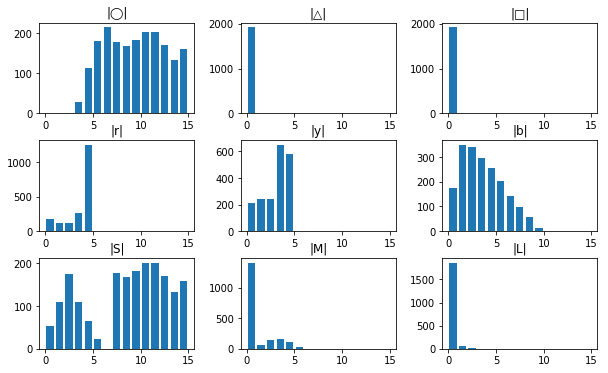

<IPython.core.display.Javascript object>

In [86]:
#@title Create Set of Errors { vertical-output: true }

error_set = PandaSet(raw_panda[mask], used_test_generator)

error_set.display_meta(test_params['figure_parameters'])

    

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,BID,BPOS,ID,Yreadable,enc|r|,enc|y|,file,|*|,|L|,|M|,|S|,|b|,|r|,|y|,|□|,|△|,|◯|,Ypredicted,mask
457,14,23,test/fig000457,"4 red ◯, 1 yellow ◯","[0, 0, 0, 0, 1, 0]","[0, 1, 0, 0, 0, 0]",fig000457.png,5,0,3,2,0,4,1,0,0,5,"3 red ◯, 1 yellow ◯",True
459,14,25,test/fig000459,"3 red ◯, 4 yellow ◯","[0, 0, 0, 1, 0, 0]","[0, 0, 0, 0, 1, 0]",fig000459.png,9,0,0,9,2,3,4,0,0,9,"3 red ◯, 3 yellow ◯",True
462,14,28,test/fig000462,"0 red ◯, 4 yellow ◯","[1, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 1, 0]",fig000462.png,7,0,0,7,3,0,4,0,0,7,"0 red ◯, 3 yellow ◯",True
500,16,4,test/fig000500,"4 red ◯, 0 yellow ◯","[0, 0, 0, 0, 1, 0]","[1, 0, 0, 0, 0, 0]",fig000500.png,5,0,4,1,1,4,0,0,0,5,"3 red ◯, 0 yellow ◯",True
511,16,15,test/fig000511,"4 red ◯, 4 yellow ◯","[0, 0, 0, 0, 1, 0]","[0, 0, 0, 0, 1, 0]",fig000511.png,10,0,0,10,2,4,4,0,0,10,"4 red ◯, 3 yellow ◯",True


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,
,
,
,
,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       ...,

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       ...,

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       ...,

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       ...,

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       ...,

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,,,,
,,,,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

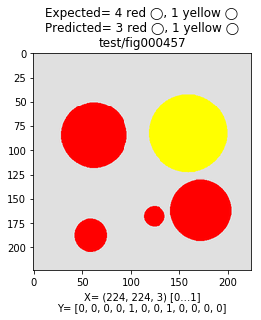

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

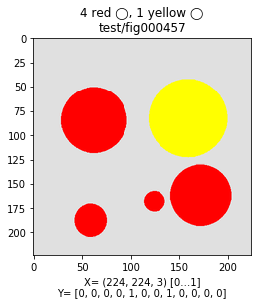

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

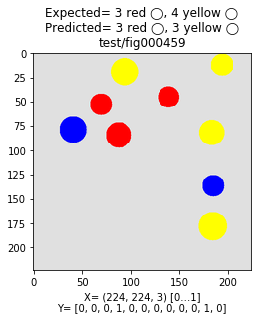

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

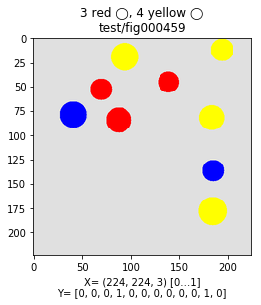

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

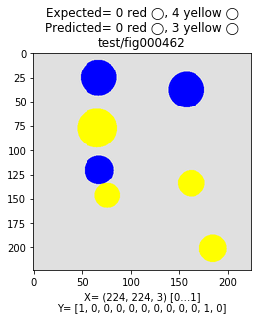

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

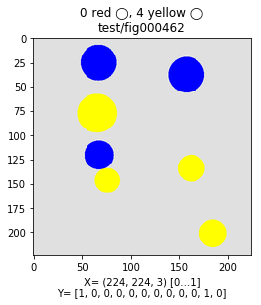

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

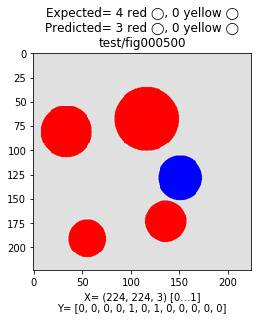

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

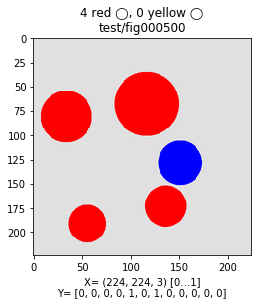

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

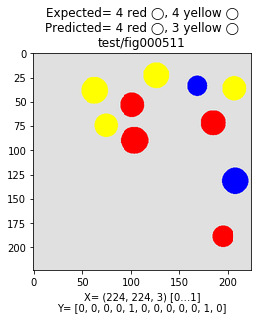

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

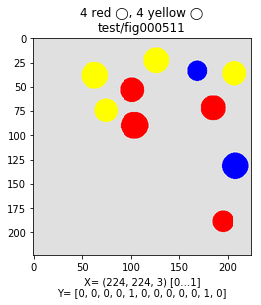

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [87]:
#@title View Error Samples { run: "auto", vertical-output: true } 
sample_to_view  = 36 #@param {type:"slider", min:0, max:10000, step:1}
view_len = 5 #@param {type:"slider", min:1, max:25, step:1}

error_set.display_content_slice(
    slice(sample_to_view, sample_to_view + view_len), 
    sample_view = lambda s, r: s.plot(verbose=0, title_prefix = "Expected= %s\nPredicted= %s"%(r['Yreadable'], r['Ypredicted'])), 
    assert_view = lambda s, r, ridx, g: s.plot(verbose=0, ),
    #Xassert = 
    #Yassert = 
)

In [0]:
# Import a function from sklearn to calculate the confusion-matrix.
from sklearn.metrics import confusion_matrix

def print_confusion_matrix(cls_pred):    
    cm = confusion_matrix(y_true=cls_test, y_pred=cls_pred) 

    print("Confusion matrix:")        
    print(cm)    
    
    for i, class_name in enumerate(class_names):
        print("({0}) {1}".format(i, class_name))

In [0]:
#https://colab.research.google.com/notebooks/charts.ipynb#scrollTo=8YCVGqZkJJxT

def enable_plotly_in_cell():
    import IPython
    from plotly.offline import init_notebook_mode
    display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
    '''))
    init_notebook_mode(connected=False)

In [0]:
from plotly.offline import iplot
import plotly.graph_objs as go

enable_plotly_in_cell()

data = [
    go.Contour(
        z=[[10, 10.625, 12.5, 15.625, 20],
           [5.625, 6.25, 8.125, 11.25, 15.625],
           [2.5, 3.125, 5., 8.125, 12.5],
           [0.625, 1.25, 3.125, 6.25, 10.625],
           [0, 0.625, 2.5, 5.625, 10]]
    )
]
iplot(data)